# Linear Models

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [2]:
path1 = Path("Data/batch1.pkl")
batch1 = pickle.load(open(path1, 'rb'))

#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [6]:
path2 = Path("Data/batch2.pkl")
batch2 = pickle.load(open(path2, 'rb'))

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [7]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [12]:
path3 = Path("Data/batch3.pkl")
batch3 = pickle.load(open(path3, 'rb'))

# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

In [13]:
bat_dict = {**batch1, **batch2, **batch3}

In [43]:
numBat1 = len(batch1.keys())
numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3


test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

## Variance Model

In [44]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [57]:
# create dataframe with Delta Qdlin and cycles as features

variances = np.array([])
cycle_life = np.array([])
for cell in bat_dict.values():
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    variances = np.append(variances, np.log(np.var(dQ_100_10)))
    cycle_life = np.append(cycle_life, cell["cycle_life"])

df = pd.DataFrame({"Delta_Qd_100_10_log_variance": variances, 
                   "cycles": cycle_life})

In [58]:
df.head()

,Delta_Qd_100_10_log_variance,cycles
0,-11.631570,1852.0
1,-11.825562,2160.0
2,-11.402131,2237.0
3,-10.099939,1434.0
4,-10.602896,1709.0


In [47]:
x_train = df.iloc[train_ind,:-1]
y_train = df.iloc[train_ind,-1:]
x_test = df.iloc[test_ind,:-1]
y_test = df.iloc[test_ind,-1:]
x_test_sec = df.iloc[secondary_test_ind,:-1]
y_test_sec = df.iloc[secondary_test_ind,-1:]

In [48]:
# train elastic net on dataframe
regr = ElasticNet(random_state=54)
regr.fit(x_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=54, selection='cyclic', tol=0.0001, warm_start=False)

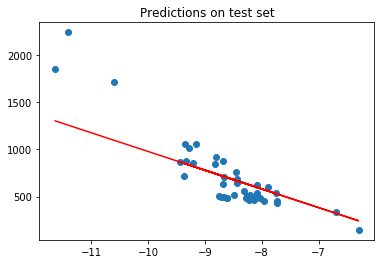

In [49]:
pred_test = regr.predict(x_test)

plt.scatter(x_test, y_test)
plt.plot(x_test, pred_test, color="red")
plt.title("Predictions on test set")
plt.show()

In [50]:
mean_squared_error(pred_test, y_test)

54407.53232260201

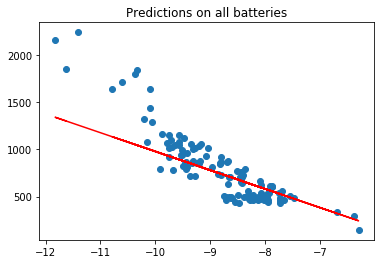

In [52]:
pred_all = regr.predict(df["Delta_Qd_100_10_variance"][:,np.newaxis])

plt.scatter(df["Delta_Qd_100_10_variance"], df["cycles"])
plt.plot(df["Delta_Qd_100_10_variance"], pred_all, color="red")
plt.title("Predictions on all batteries")
plt.show()